### **USING  AUTO REGRESSION (VAR)**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # module for plotting 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
# load cleaned dataset
dataset = pd.read_csv('/content/drive/My Drive/cleandailySolarWithFeatures .csv', header=0, index_col=0)
data = dataset[dataset.day_type != 1]
data.reset_index()
np.random.seed(107)
values = data[['Solar_Power_Generation( Kw)']]

### Checking the stationarity of time series

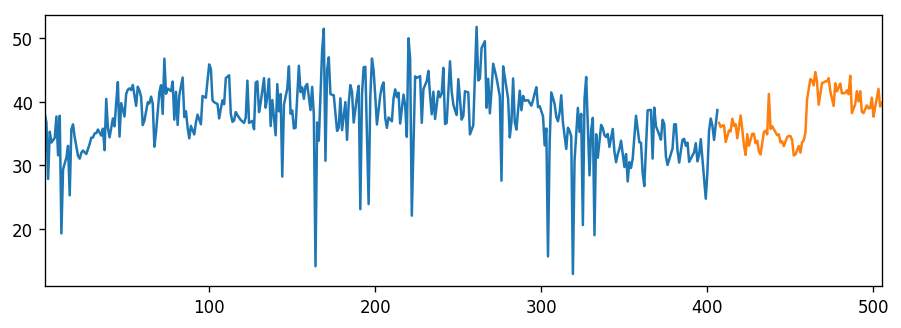

In [0]:
#creating the train and validation set
train = values[:int(0.8*(len(data)))]
valid = values[int(0.8*(len(data))):]

#plotting the data
train['Solar_Power_Generation( Kw)'].plot()
valid['Solar_Power_Generation( Kw)'].plot()


**Checking stationarity of the model**

In [0]:
#checking the stationarity of the model
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Solar Power Generation")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [0]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])
    #if the test value is less than the critical value, then null hypothesis can be rejected and the time series will be stationary (null hypothesis assumes Time Series is non-stationary)

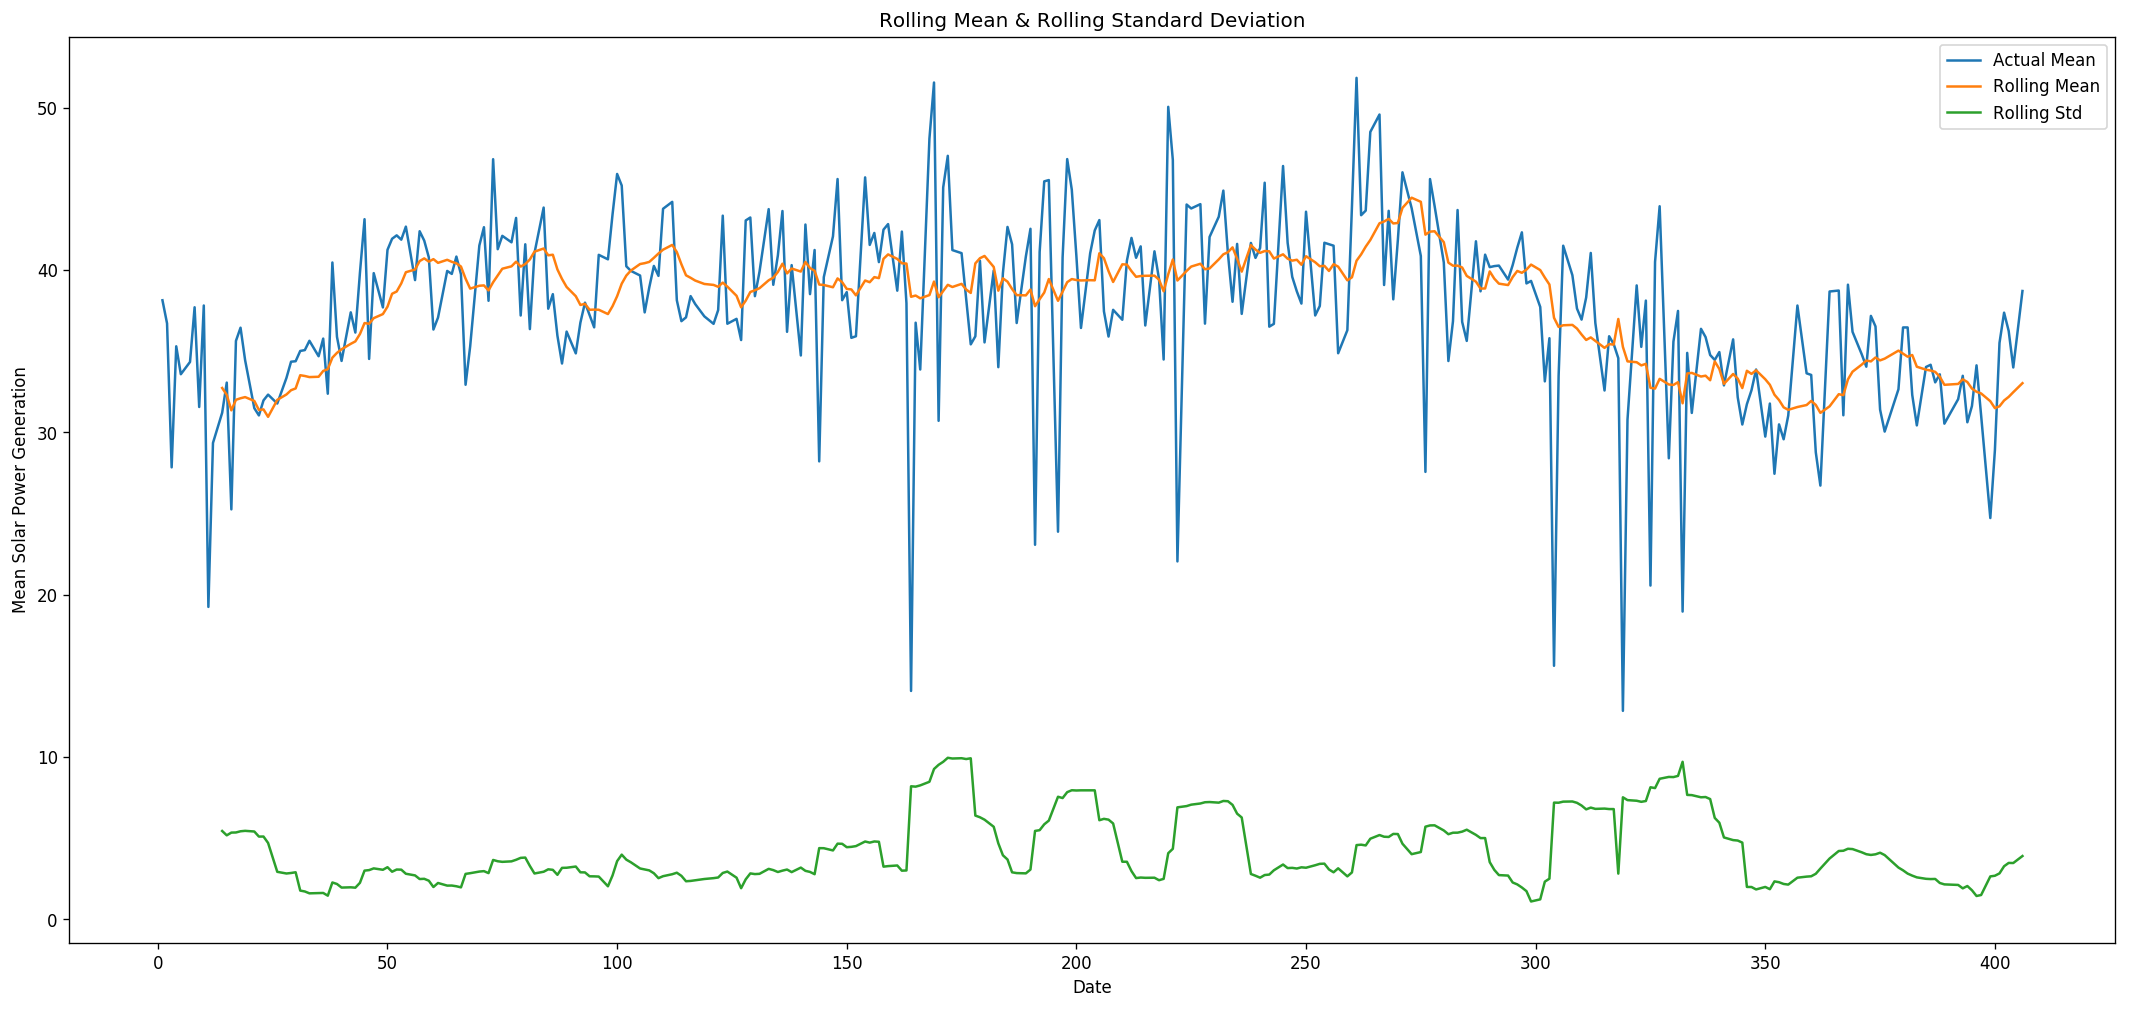

Test statistic:  -2.1552149281410893
Critical Values: {'1%': -3.45050711373316, '5%': -2.8704195794076743, '10%': -2.571500856923753}


In [0]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train['Solar_Power_Generation( Kw)'])
perform_dickey_fuller_test(train['Solar_Power_Generation( Kw)'])

### **Since test value > critical values, the model is not stationary**

### **Differencing helps improving Stationarity of the model. 2 diffrencing steps will be performed**

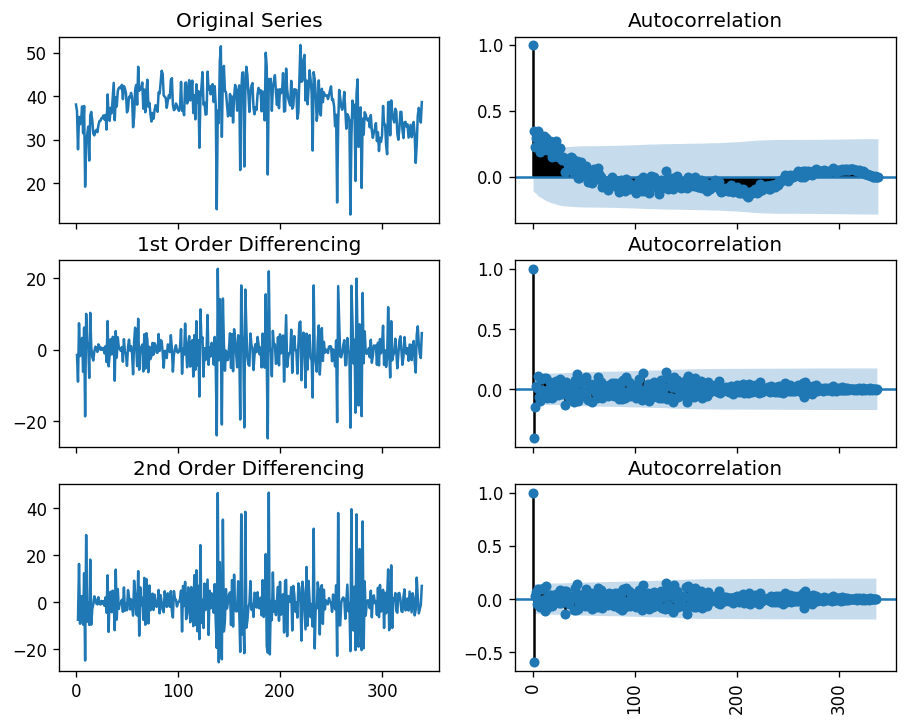

In [0]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train['Solar_Power_Generation( Kw)'].values); 
axes[0, 0].set_title('Original Series')
plot_acf(train['Solar_Power_Generation( Kw)'].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train['Solar_Power_Generation( Kw)'].diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train['Solar_Power_Generation( Kw)'].diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train['Solar_Power_Generation( Kw)'].diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train['Solar_Power_Generation( Kw)'].diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

### ** Here we can stop with doing first differencing since the autocorrelation is clustered to the origin
PACF- the degree of measure of autocorrelation between x(t) and x(t-p)(past values) **

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


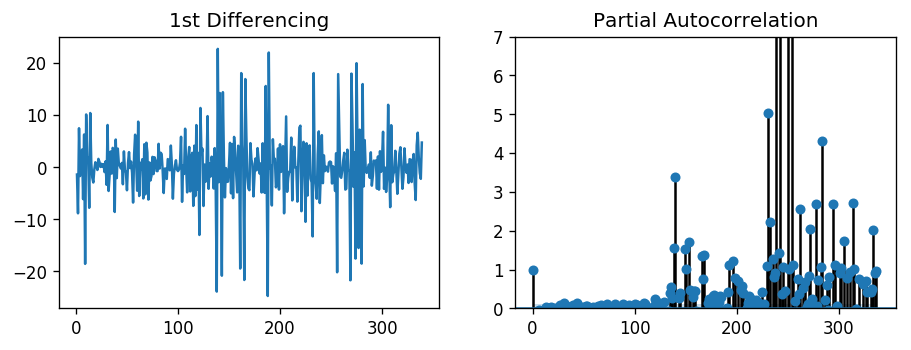

In [0]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train['Solar_Power_Generation( Kw)'].diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,7))
plot_pacf(train['Solar_Power_Generation( Kw)'].diff().dropna().values, ax=axes[1])

plt.show()

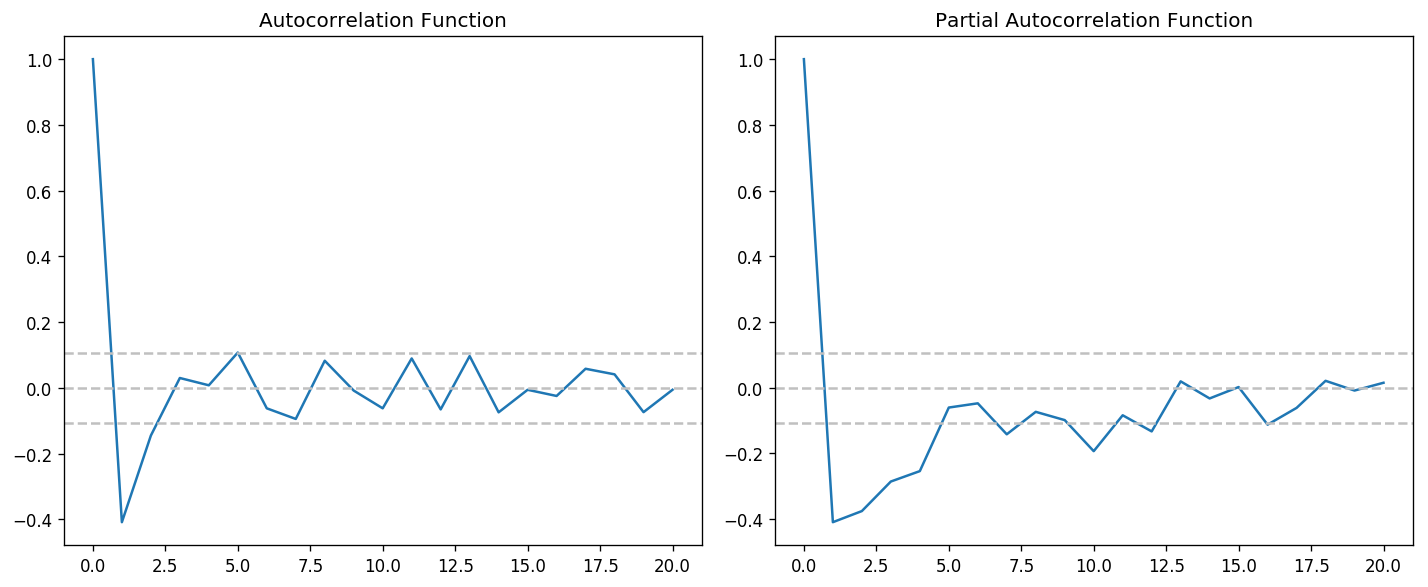

In [0]:
acf_lag = acf(train['Solar_Power_Generation( Kw)'].diff().dropna().values, nlags=20)
pacf_lag = pacf(train['Solar_Power_Generation( Kw)'].diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train['Solar_Power_Generation( Kw)'].diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train['Solar_Power_Generation( Kw)'].diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train['Solar_Power_Generation( Kw)'].diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train['Solar_Power_Generation( Kw)'].diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()                                        

### **Building the ARIMA model**
We use 3 parameters for this model
1. p - value where PACF passes the upper confidence level ( p =1 )
2.q - the point where ACF crosses the upper confiednce level.q = 1.
3. d - number of non seasonal differences here d=0 since the model is made stationary

In [0]:
model = ARIMA(train.values, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  340
Model:                     ARMA(2, 1)   Log Likelihood               -1019.273
Method:                       css-mle   S.D. of innovations              4.843
Date:                Wed, 29 May 2019   AIC                           2048.547
Time:                        10:20:01   BIC                           2067.691
Sample:                             0   HQIC                          2056.175
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4461      2.005     18.182      0.000      32.517      40.375
ar.L1.y        1.0539      0.061     17.316      0.000       0.935       1.173
ar.L2.y       -0.0656      0.059     -1.119      0.2

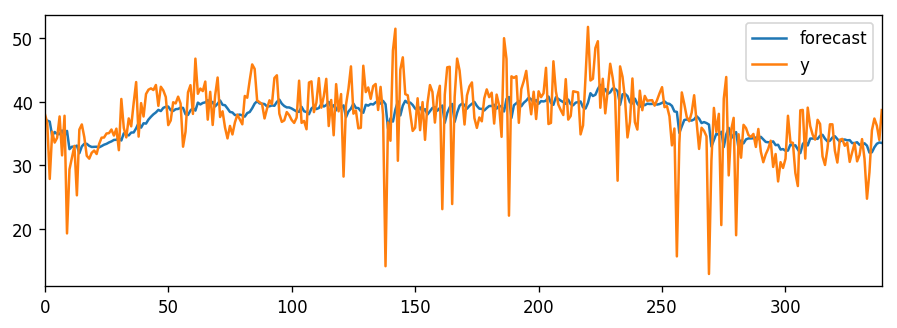

In [0]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

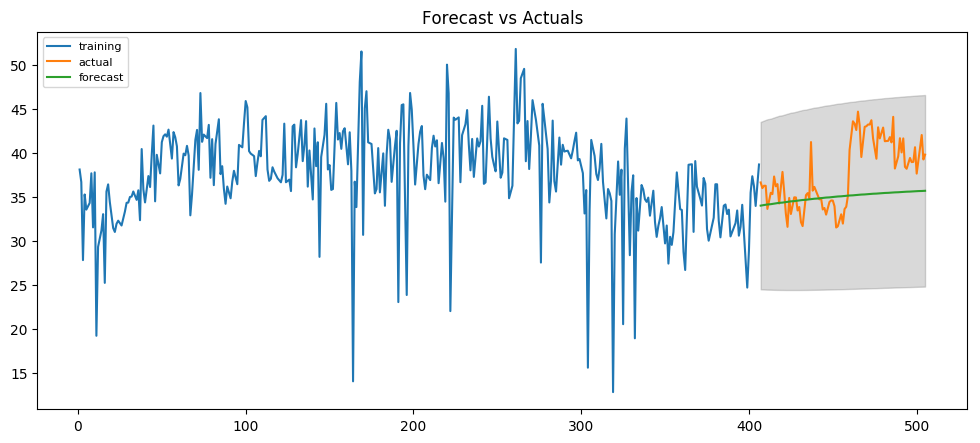

In [0]:
fc, se, conf = model_fit.forecast(85, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=valid.index)
lower_series = pd.Series(conf[:, 0], index=valid.index)
upper_series = pd.Series(conf[:, 1], index=valid.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(valid, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()